In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import torch.optim as optim
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Loading Training Data and Target Scaling

We begin by loading the pre-processed dataset containing:
- `X`: 90-day rolling windows of reduced ESG news embeddings.
- `y`: Quarterly ESG scores (raw targets).
- `tickers`, `categories`, `target_dates`: Metadata for traceability.

After loading, we normalize the target variable (`y`) using a **MinMaxScaler** to scale values into the [0,1] range.

In [ ]:
input_path = "/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/ESG_TRAIN_READY_2.pkl"

with open(input_path, "rb") as f:
    data = pickle.load(f)

X = data["X"]
y = data["y"]
tickers = data["tickers"]
categories = data["categories"]
target_dates = data["target_dates"]

print(f"Ventanas cargadas: {len(X)} | Ejemplo shape: {X[0].shape}")

scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(np.array(y).reshape(-1, 1)).flatten()

Ventanas cargadas: 51489 | Ejemplo shape: (90, 101)


In [ ]:
class ESGDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, device="cpu"):
        self.X = torch.tensor(np.array(X), dtype=torch.float32).to(device)
        self.y = torch.tensor(np.array(y), dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ESGDataset(X, y_scaled, device=device)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Defining the ESG_LSTM Model Architecture

We define the `ESG_LSTM` class, a PyTorch neural network designed to predict quarterly ESG scores based on sequences of news embeddings.

Key architectural choices:
- **Bidirectional LSTM**:
  - Two layers (`num_layers=2`) with hidden dimension 128.
  - Processes sequences forward and backward, allowing the model to capture both past and future patterns within the input window.
- **Dropout (p=0.3)**:
  - Applied after the last LSTM output to prevent overfitting.
- **Fully Connected Layers**:
  - `fc1`: Projects the concatenated bidirectional hidden state (256 dimensions) back to 128 dimensions.
  - `fc2`: Maps the 128-dimensional intermediate representation to a single scalar ESG score prediction.

Why use a bidirectional LSTM?
- ESG news impacts can have cumulative effects over time and may not be strictly forward in temporal influence.
- Bidirectional LSTMs allow the model to consider both preceding and following context within a window, improving prediction quality.

The final output is squeezed to ensure a proper 1D output shape for regression loss calculation.

In [ ]:
class ESG_LSTM(nn.Module):
    def __init__(self, input_dim=101, hidden_dim=128, num_layers=2):
        super(ESG_LSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        out = self.relu(self.fc1(out))

        return self.fc2(out).squeeze(1)

# Splitting the Dataset into Train, Validation, and Test Sets

We split the dataset into three subsets:
- **70% Training Set**: Used to optimize model weights.
- **15% Validation Set**: Used to monitor model performance during training and apply early stopping or hyperparameter tuning.
- **15% Test Set**: Used exclusively for final evaluation after training.

Splitting strategy:
- First, we split into 70% train and 30% temporary (`X_temp`, `y_temp`).
- Then, we split the temporary set equally into validation and test (50%-50%).

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_dataset = ESGDataset(X_train, y_train)
val_dataset = ESGDataset(X_val, y_val)
test_dataset = ESGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training the ESG_LSTM Model

We now train the `ESG_LSTM` model using the prepared training and validation sets.

Steps taken:
- **Random seed fixation**: Seeds are set for Python, NumPy, and PyTorch to ensure full reproducibility of results (critical for academic and professional rigor).
- **Device selection**: The model is moved to GPU if available for faster training.
- **Model definition**: The LSTM network is initialized with the previously defined architecture.
- **Loss function**: Mean Squared Error (MSE) is used, as this is a regression task predicting continuous ESG scores.
- **Optimizer**: Adam optimizer is selected with a learning rate of 0.001, offering an adaptive learning rate mechanism well-suited for deep networks.

### Training strategy:
- We train the model for 20 epochs.
- After each epoch:
  - Train and validation losses are computed.
  - If validation loss improves, the model's weights are saved immediately (`best_model.pth`).

In [ ]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ESG_LSTM(input_dim=101).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 20
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/best_model.pth")
        print(f"Modelo mejorado guardado en epoch {epoch+1}")

Epoch 1/20 | Train Loss: 0.0128 | Validation Loss: 0.0043
Modelo mejorado guardado en epoch 1
Epoch 2/20 | Train Loss: 0.0034 | Validation Loss: 0.0024
Modelo mejorado guardado en epoch 2
Epoch 3/20 | Train Loss: 0.0021 | Validation Loss: 0.0015
Modelo mejorado guardado en epoch 3
Epoch 4/20 | Train Loss: 0.0017 | Validation Loss: 0.0016
Epoch 5/20 | Train Loss: 0.0014 | Validation Loss: 0.0010
Modelo mejorado guardado en epoch 5
Epoch 6/20 | Train Loss: 0.0016 | Validation Loss: 0.0014
Epoch 7/20 | Train Loss: 0.0017 | Validation Loss: 0.0012
Epoch 8/20 | Train Loss: 0.0011 | Validation Loss: 0.0009
Modelo mejorado guardado en epoch 8
Epoch 9/20 | Train Loss: 0.0009 | Validation Loss: 0.0006
Modelo mejorado guardado en epoch 9
Epoch 10/20 | Train Loss: 0.0007 | Validation Loss: 0.0009
Epoch 11/20 | Train Loss: 0.0013 | Validation Loss: 0.0011
Epoch 12/20 | Train Loss: 0.0010 | Validation Loss: 0.0007
Epoch 13/20 | Train Loss: 0.0007 | Validation Loss: 0.0005
Modelo mejorado guardado e

# Final Evaluation on Test Set

After completing training and validation, we proceed to evaluate the model's generalization performance on the untouched test set.

Steps:
- **Model loading**: The best model (lowest validation loss) is reloaded to ensure fair testing.
- **Prediction**: The model outputs predictions for all test batches without updating weights (`torch.no_grad()`).
- **Inverse scaling**: Both predictions and true labels are inverse-transformed to their original scale using the stored `MinMaxScaler`.
- **Metric computation**:
  - **Mean Squared Error (MSE)**: Measures average squared difference between predicted and actual ESG scores.
  - **Coefficient of Determination (R²)**: Measures how well the model explains variance in the real ESG scores.

### Results:
- Test MSE ≈ 0.85
- Test R² ≈ 0.986

Interpretation:
- The very high R² score (> 0.98) indicates excellent predictive power.
- The relatively low MSE suggests that most predictions are very close to true values.

This final evaluation confirms that the LSTM model generalizes well to unseen ESG data and is suitable for real-world application scenarios.

In [ ]:
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)

        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())

y_pred_real = scaler.inverse_transform(np.array(all_preds).reshape(-1, 1)).flatten()
y_true_real = scaler.inverse_transform(np.array(all_targets).reshape(-1, 1)).flatten()
mse = mean_squared_error(y_true_real, y_pred_real)
r2 = r2_score(y_true_real, y_pred_real)

print(f"Test MSE (real): {mse:.2f}")
print(f"Test R² (real): {r2:.3f}")

Test MSE (real): 0.85
Test R² (real): 0.986


In [ ]:
random.seed(3)
sample_indices = random.sample(range(len(y_pred_real)), 10)

print("Sample of ESG predictions vs. actual scores on the test set:\n")

for i in sample_indices:
    pred = y_pred_real[i]
    real = y_true_real[i]
    error = abs(pred - real)
    print(f"Predicted: {pred:.2f} | Actual: {real:.2f} | Absolute Error: {error:.2f}")

Sample of ESG predictions vs. actual scores on the test set:

Predicted: 66.52 | Actual: 66.14 | Absolute Error: 0.38
Predicted: 57.65 | Actual: 56.87 | Absolute Error: 0.78
Predicted: 47.30 | Actual: 45.81 | Absolute Error: 1.49
Predicted: 72.68 | Actual: 73.46 | Absolute Error: 0.78
Predicted: 66.49 | Actual: 66.45 | Absolute Error: 0.04
Predicted: 61.56 | Actual: 60.77 | Absolute Error: 0.79
Predicted: 50.59 | Actual: 50.74 | Absolute Error: 0.15
Predicted: 54.30 | Actual: 54.40 | Absolute Error: 0.10
Predicted: 65.57 | Actual: 66.54 | Absolute Error: 0.97
Predicted: 55.18 | Actual: 54.78 | Absolute Error: 0.40


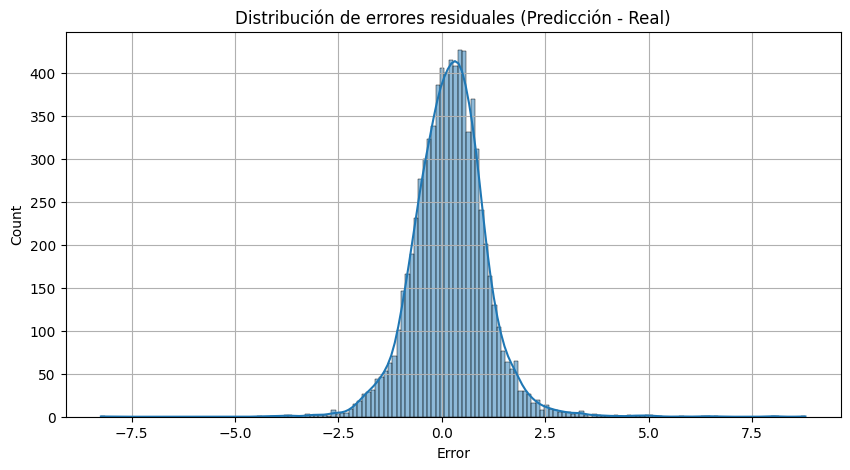

In [ ]:
residuals = y_pred_real - y_true_real

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title("Distribución de errores residuales (Predicción - Real)")
plt.xlabel("Error")
plt.grid(True)
plt.show()

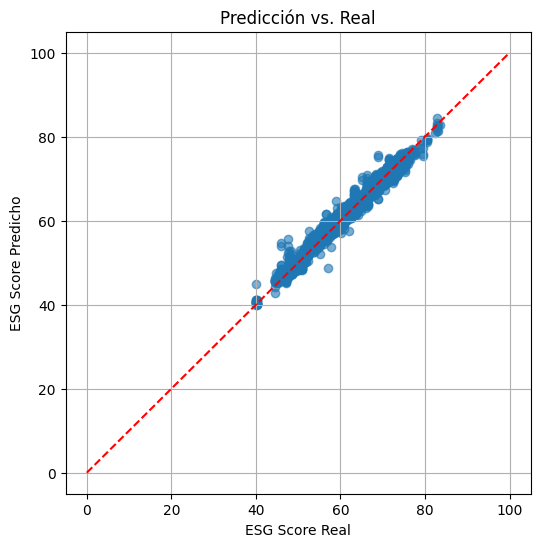

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true_real, y_pred_real, alpha=0.6)
plt.plot([0, 100], [0, 100], linestyle="--", color="red")
plt.xlabel("ESG Score Real")
plt.ylabel("ESG Score Predicho")
plt.title("Predicción vs. Real")
plt.grid(True)
plt.show()

In [ ]:
print(f"Máx predicho: {np.max(y_pred_real):.2f}")
print(f"Mín predicho: {np.min(y_pred_real):.2f}")

Máx predicho: 84.41
Mín predicho: 39.89


In [ ]:
model_path = "/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/ESG_LSTM_MODEL.pth"
scaler_path = "/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/ESG_SCALER.pkl"

torch.save(model.state_dict(), model_path)
joblib.dump(scaler, scaler_path)

print("Modelo y scaler guardados correctamente.")

Modelo y scaler guardados correctamente.


In [ ]:
path = "/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/WINDOWS.pkl"
with open(path, "rb") as f:
    data = pickle.load(f)

X = data["X"]
tickers = data["tickers"]
categories = data["categories"]
target_dates = data["target_dates"]

# Generating Full Dataset Predictions

To facilitate further analysis, we generate predictions for the entire dataset (all available windows).

Steps:
- **DataLoader preparation**: We wrap all input sequences into a PyTorch `TensorDataset` and use a DataLoader (batch size = 512) for efficient inference.
- **Model evaluation**: We set the model to evaluation mode (`model.eval()`) to disable dropout and batch normalization updates.
- **Prediction**:
  - We predict scores for all windows without tracking gradients (`torch.no_grad()`).
  - Predictions are collected batch by batch and concatenated.
- **Inverse scaling**:
  - Predicted scores are transformed back to their original scale using the saved `MinMaxScaler`.
- **Storage**:
  - We create a DataFrame (`df_preds`) associating each prediction with its corresponding ticker, ESG category, and target date.

In [ ]:
dataset = TensorDataset(torch.tensor(np.array(X), dtype=torch.float32))
loader = DataLoader(dataset, batch_size=512, shuffle=False)

model.eval()

all_preds = []

with torch.no_grad():
    for batch in loader:
        batch_X = batch[0].to(device)
        outputs = model(batch_X)
        all_preds.extend(outputs.cpu().numpy())

y_pred_real = scaler.inverse_transform(np.array(all_preds).reshape(-1, 1)).flatten()

df_preds = pd.DataFrame({
    "ticker": tickers,
    "category": categories,
    "target_date": pd.to_datetime(target_dates),
    "predicted_score": y_pred_real
})

print("Predicciones generadas correctamente con DataLoader.")
display(df_preds.head())

Predicciones generadas correctamente con DataLoader.


,ticker,category,target_date,predicted_score
0,AAPL,Environmental,2020-07-01,72.048332
1,AAPL,Environmental,2020-07-02,72.323982
2,AAPL,Environmental,2020-07-03,72.354248
3,AAPL,Environmental,2020-07-05,72.138847
4,AAPL,Environmental,2020-07-06,72.300812


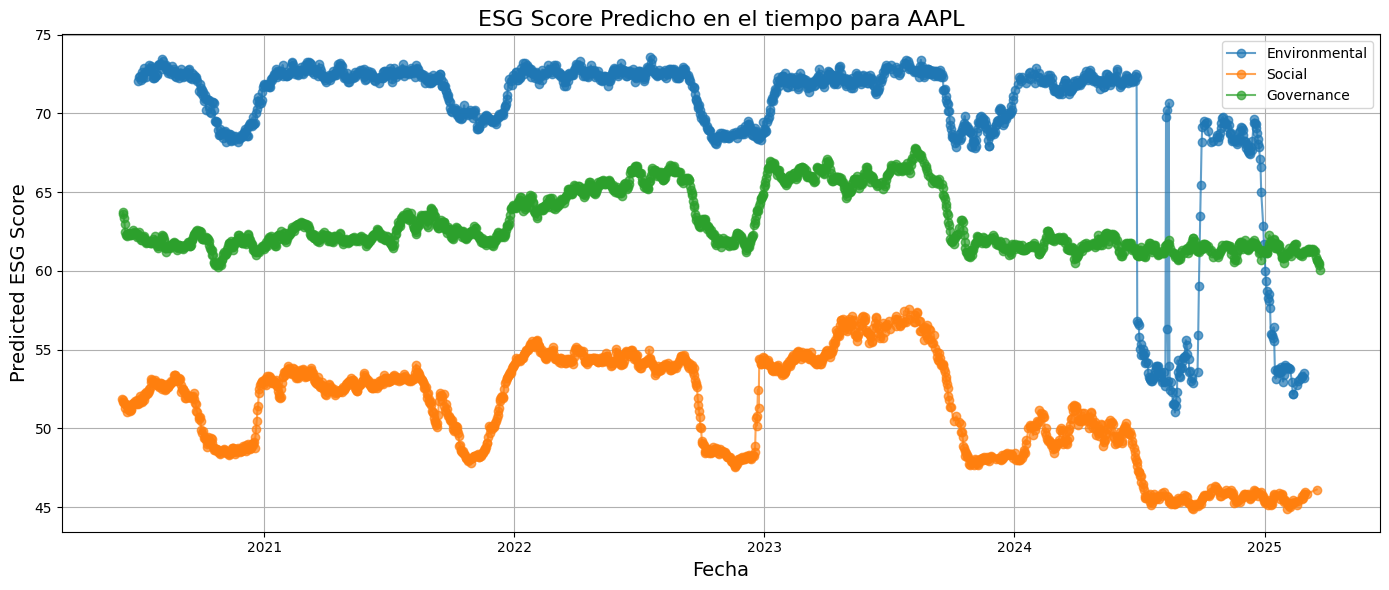

In [ ]:
ticker_to_plot = "AAPL"

df_plot = df_preds[df_preds["ticker"] == ticker_to_plot]
plt.figure(figsize=(14, 6))

for category in ["Environmental", "Social", "Governance"]:
    df_cat = df_plot[df_plot["category"] == category]
    plt.plot(
        df_cat["target_date"],
        df_cat["predicted_score"],
        label=category,
        marker="o",
        alpha=0.7
    )

plt.title(f"ESG Score Predicho en el tiempo para {ticker_to_plot}", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Predicted ESG Score", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

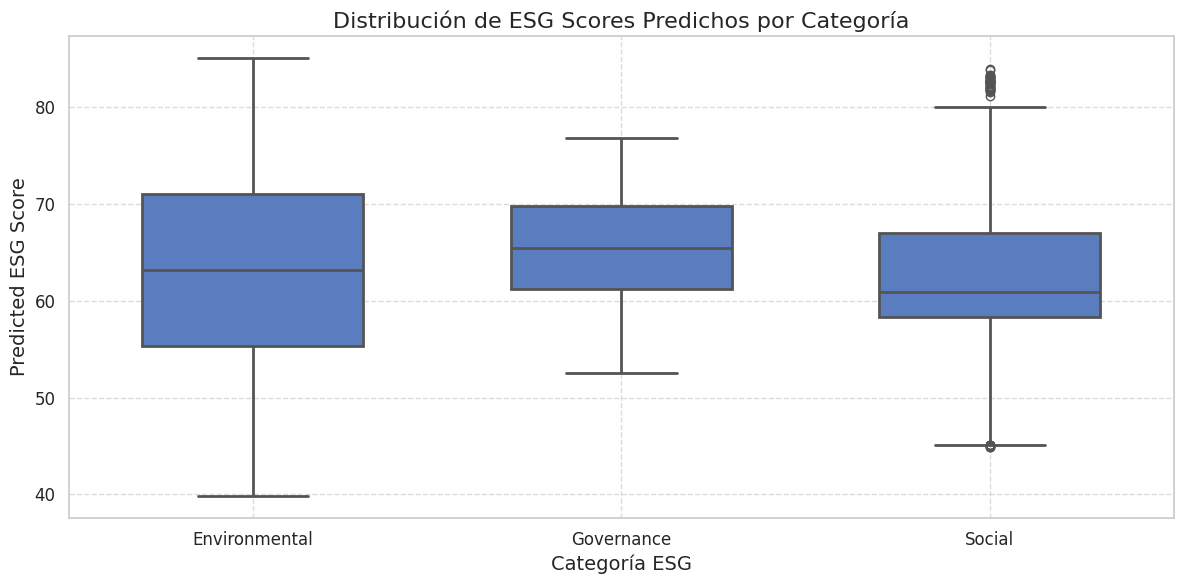

In [ ]:
sns.set(style="whitegrid", palette="muted")

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_preds,
    x="category",
    y="predicted_score",
    width=0.6,
    showfliers=True,
    linewidth=2
)

plt.title("Distribución de ESG Scores Predichos por Categoría", fontsize=16)
plt.xlabel("Categoría ESG", fontsize=14)
plt.ylabel("Predicted ESG Score", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
df_preds

,ticker,category,target_date,predicted_score
0,AAPL,Environmental,2020-07-01,72.048332
1,AAPL,Environmental,2020-07-02,72.323982
2,AAPL,Environmental,2020-07-03,72.354248
3,AAPL,Environmental,2020-07-05,72.138847
4,AAPL,Environmental,2020-07-06,72.300812
...,...,...,...,...
63396,XOM,Social,2024-11-01,73.365211
63397,XOM,Social,2024-11-08,73.563446
63398,XOM,Social,2024-11-15,73.662567
63399,XOM,Social,2024-11-27,74.006615


In [ ]:
path = '/content/drive/MyDrive/MIAX/TRABAJO FINAL DE MASTER DEFINITIVO/DAILY_ESG_PREDICTIONS.csv'
df_preds.to_csv(path, index=False)